In [1]:
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report , ConfusionMatrixDisplay

#Deep learnings tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Conv2D , MaxPooling2D , Flatten , Activation , Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
from keras.applications import Xception,VGG16,ResNet50
#warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import zipfile
import os

# Path to the ZIP file
zip_file_path = '/content/drive/MyDrive/scence classification zipped/archive.zip'

# Directory where you want to extract the contents
extract_dir = 'extracted_files'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)


## Data Prepararion

In [5]:
train_data = '/content/extracted_files/seg_train/seg_train'
test_data = '/content/extracted_files/seg_test/seg_test'

filepath= []
label =[]

folds = os.listdir(train_data)

for fold in folds:
    f_path = os.path.join(train_data , fold)
    imgs = os.listdir(f_path)

    for img in imgs:
        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)

#Concat data paths with labels
fseries = pd.Series(filepath , name= 'filepaths')
lseries = pd.Series(label , name = 'labels')
train_df = pd.concat([fseries , lseries] , axis = 1)

In [6]:
folds = os.listdir(test_data)

for fold in folds:
    f_path = os.path.join(test_data , fold)
    imgs = os.listdir(f_path)

    for img in imgs:
        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)

#Concat data paths with labels
fseries = pd.Series(filepath , name= 'filepaths')
lseries = pd.Series(label , name = 'labels')
ts_df = pd.concat([fseries , lseries] , axis = 1)

In [7]:
train_df

filepaths  labels
0      /content/extracted_files/seg_train/seg_train/s...     sea
1      /content/extracted_files/seg_train/seg_train/s...     sea
2      /content/extracted_files/seg_train/seg_train/s...     sea
3      /content/extracted_files/seg_train/seg_train/s...     sea
4      /content/extracted_files/seg_train/seg_train/s...     sea
...                                                  ...     ...
14029  /content/extracted_files/seg_train/seg_train/s...  street
14030  /content/extracted_files/seg_train/seg_train/s...  street
14031  /content/extracted_files/seg_train/seg_train/s...  street
14032  /content/extracted_files/seg_train/seg_train/s...  street
14033  /content/extracted_files/seg_train/seg_train/s...  street

[14034 rows x 2 columns]

In [8]:
ts_df

filepaths  labels
0      /content/extracted_files/seg_train/seg_train/s...     sea
1      /content/extracted_files/seg_train/seg_train/s...     sea
2      /content/extracted_files/seg_train/seg_train/s...     sea
3      /content/extracted_files/seg_train/seg_train/s...     sea
4      /content/extracted_files/seg_train/seg_train/s...     sea
...                                                  ...     ...
17029  /content/extracted_files/seg_test/seg_test/str...  street
17030  /content/extracted_files/seg_test/seg_test/str...  street
17031  /content/extracted_files/seg_test/seg_test/str...  street
17032  /content/extracted_files/seg_test/seg_test/str...  street
17033  /content/extracted_files/seg_test/seg_test/str...  street

[17034 rows x 2 columns]

## Data Splitting

In [13]:
valid , test = train_test_split(ts_df , test_size= 0.5 , shuffle = True , random_state = 42)

In [14]:
print(f"Shape of Validation set is: {valid.shape}")
print(f"Shape of Test set is: {test.shape}")

Shape of Validation set is: (8517, 2)
Shape of Test set is: (8517, 2)


In [15]:
img_size = (150 ,150)
batch_size = 32

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

original_train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'labels' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 17034 validated image filenames belonging to 6 classes.
Found 8517 validated image filenames belonging to 6 classes.
Found 8517 validated image filenames belonging to 6 classes.


In [16]:
def random_label_flipping(dataframe, class_labels, flip_percentage=0.1):
    # Determine the number of samples to flip
    num_samples = len(dataframe)
    num_to_flip = int(num_samples * flip_percentage)

    # Randomly choose indices to flip
    flip_indices = np.random.choice(num_samples, size=num_to_flip, replace=False)

    # Dictionary to store the mapping of flipped indices to new class names
    flipped_mapping = {}

    # Flip the labels
    for idx in flip_indices:
        current_label = dataframe.iloc[idx]['labels']
        current_label_index = class_labels.index(current_label)
        # Choose a new label different from the current one
        new_label_index = np.random.choice([i for i in range(len(class_labels)) if i != current_label_index])
        new_label = class_labels[new_label_index]
        dataframe.at[idx, 'labels'] = new_label
        # Store the mapping of the flipped index to the new class name
        flipped_mapping[idx] = new_label

    return dataframe, flipped_mapping

# Example class labels
class_labels = list( train_df['labels'].unique())

# Load your dataframes (example)
# train_df = pd.read_csv('path/to/train.csv')
# valid = pd.read_csv('path/to/valid.csv')
# test = pd.read_csv('path/to/test.csv')

# Apply label flipping to the train_df and get the mapping of flipped indices
train_df, flipped_mapping = random_label_flipping(ts_df, class_labels, flip_percentage=0.1)

# Convert labels to strings
train_df['labels'] = train_df['labels'].astype(str)
valid['labels'] = valid['labels'].astype(str)
test['labels'] = test['labels'].astype(str)

# Print the mapping of flipped indices to new class names
print("Mapping of flipped indices to new class names:")
for index, new_class in flipped_mapping.items():
    print(f"Index: {index}, New Class: {new_class}")

# Define image size and batch size
img_size = (150, 150)
batch_size = 32

# Create ImageDataGenerators
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

# Create data generators
train_gen = tr_gen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen = ts_gen.flow_from_dataframe(
    valid,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen = ts_gen.flow_from_dataframe(
    test,
    x_col='filepaths',
    y_col='labels',
    target_size=img_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Mapping of flipped indices to new class names:
Index: 515, New Class: street
Index: 7082, New Class: glacier
Index: 6182, New Class: buildings
Index: 3539, New Class: street
Index: 7322, New Class: street
Index: 2189, New Class: glacier
Index: 7124, New Class: forest
Index: 3810, New Class: buildings
Index: 4953, New Class: forest
Index: 6229, New Class: sea
Index: 3898, New Class: mountain
Index: 13307, New Class: glacier
Index: 4027, New Class: mountain
Index: 378, New Class: glacier
Index: 12698, New Class: glacier
Index: 7361, New Class: street
Index: 16746, New Class: glacier
Index: 3632, New Class: buildings
Index: 6502, New Class: forest
Index: 11946, New Class: mountain
Index: 13989, New Class: forest
Index: 9450, New Class: buildings
Index: 80, New Class: buildings
Index: 16764, New Class: sea
Index: 2069, New Class: glacier
Index: 14406, New Class: street
Index: 115, New Class: street
Index: 11763, New Class: forest
Index: 10812, New Class: forest
Index: 11200, New Class: for

## Image Generator

## Show Sample from Train Data

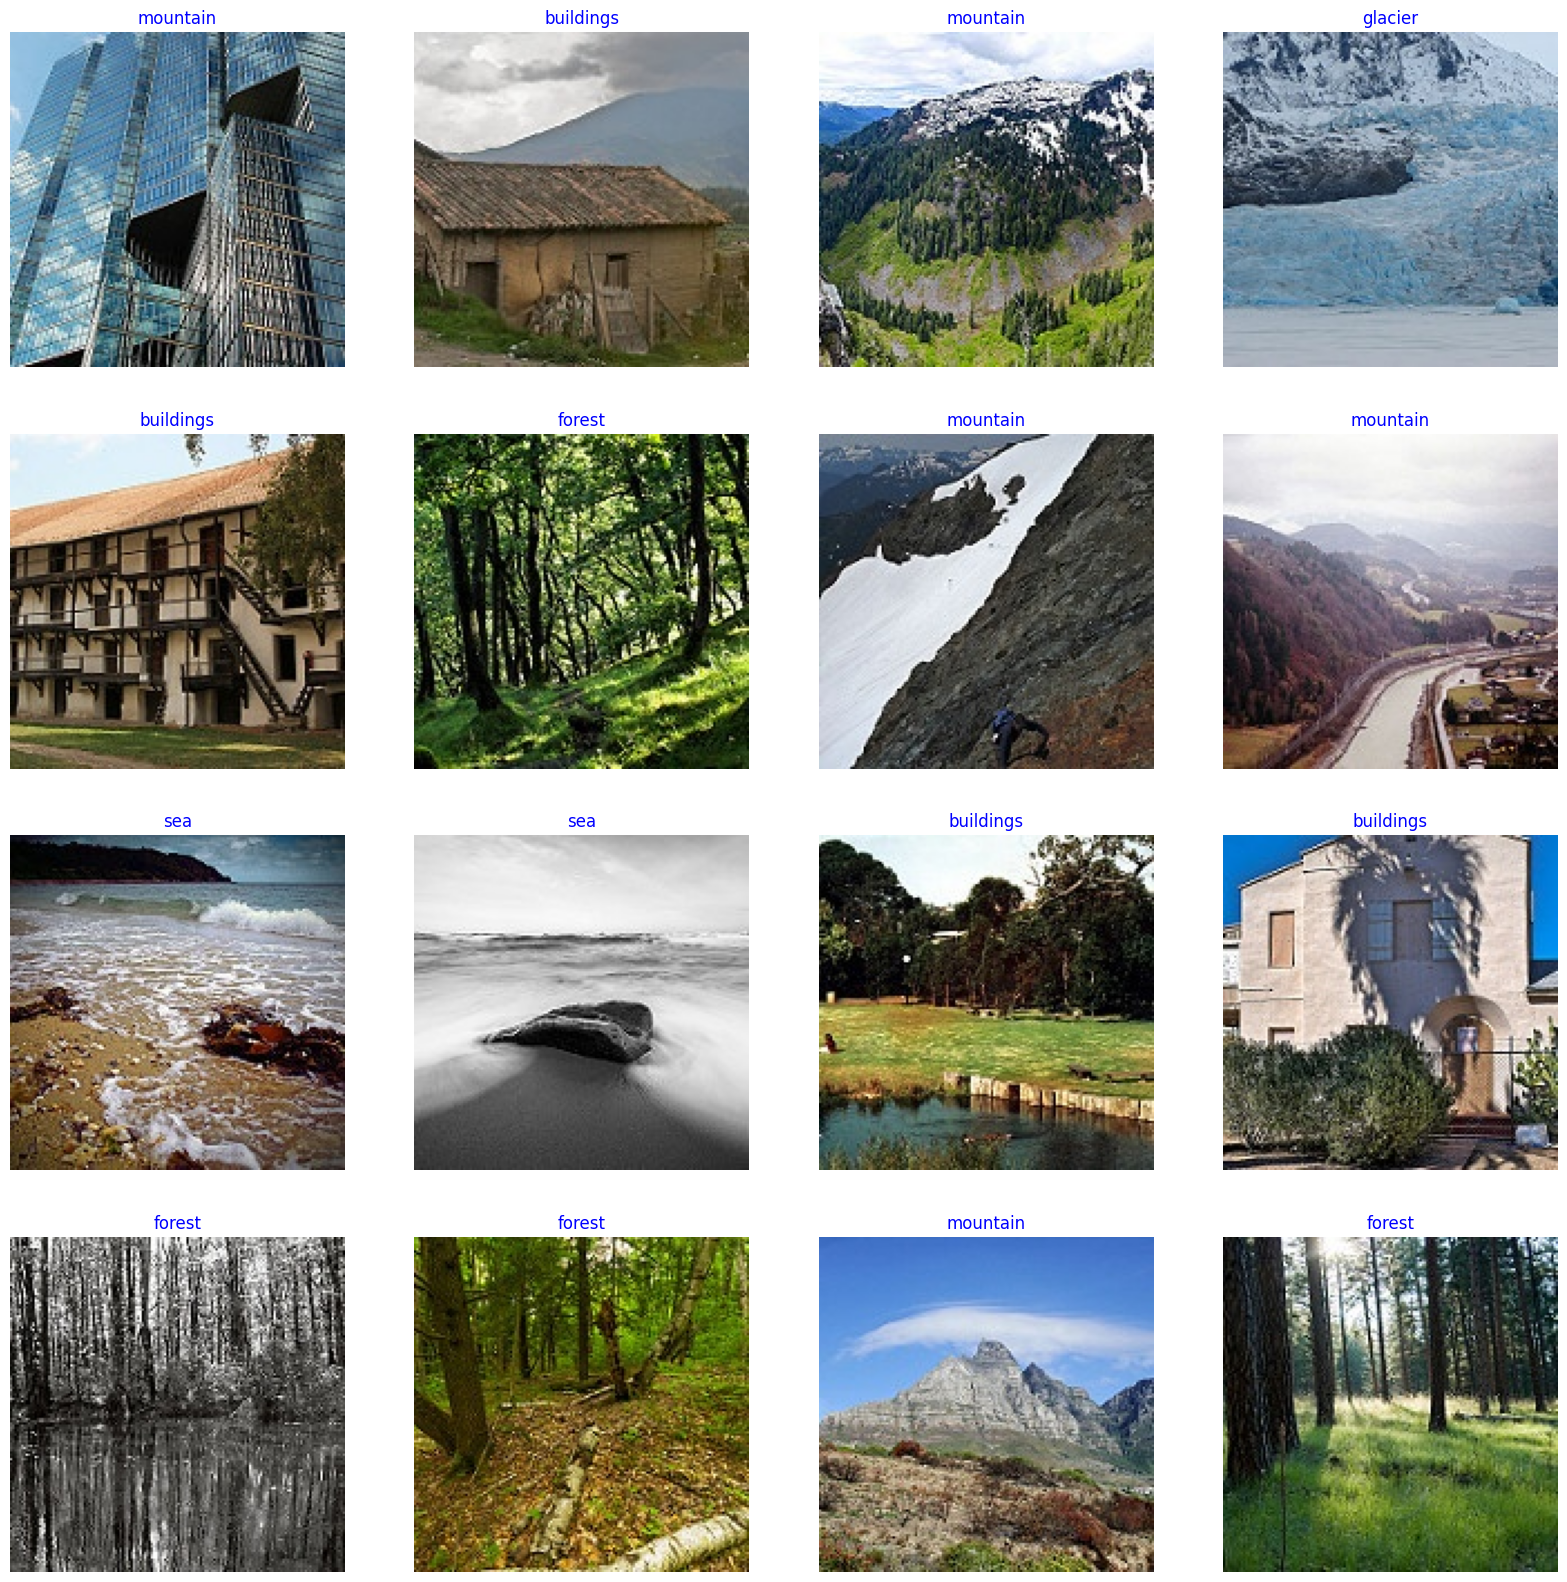

In [17]:
dict_gen = original_train_gen.class_indices
classes = list(dict_gen.keys())
images , labels = next(original_train_gen)

plt.figure(figsize=(20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

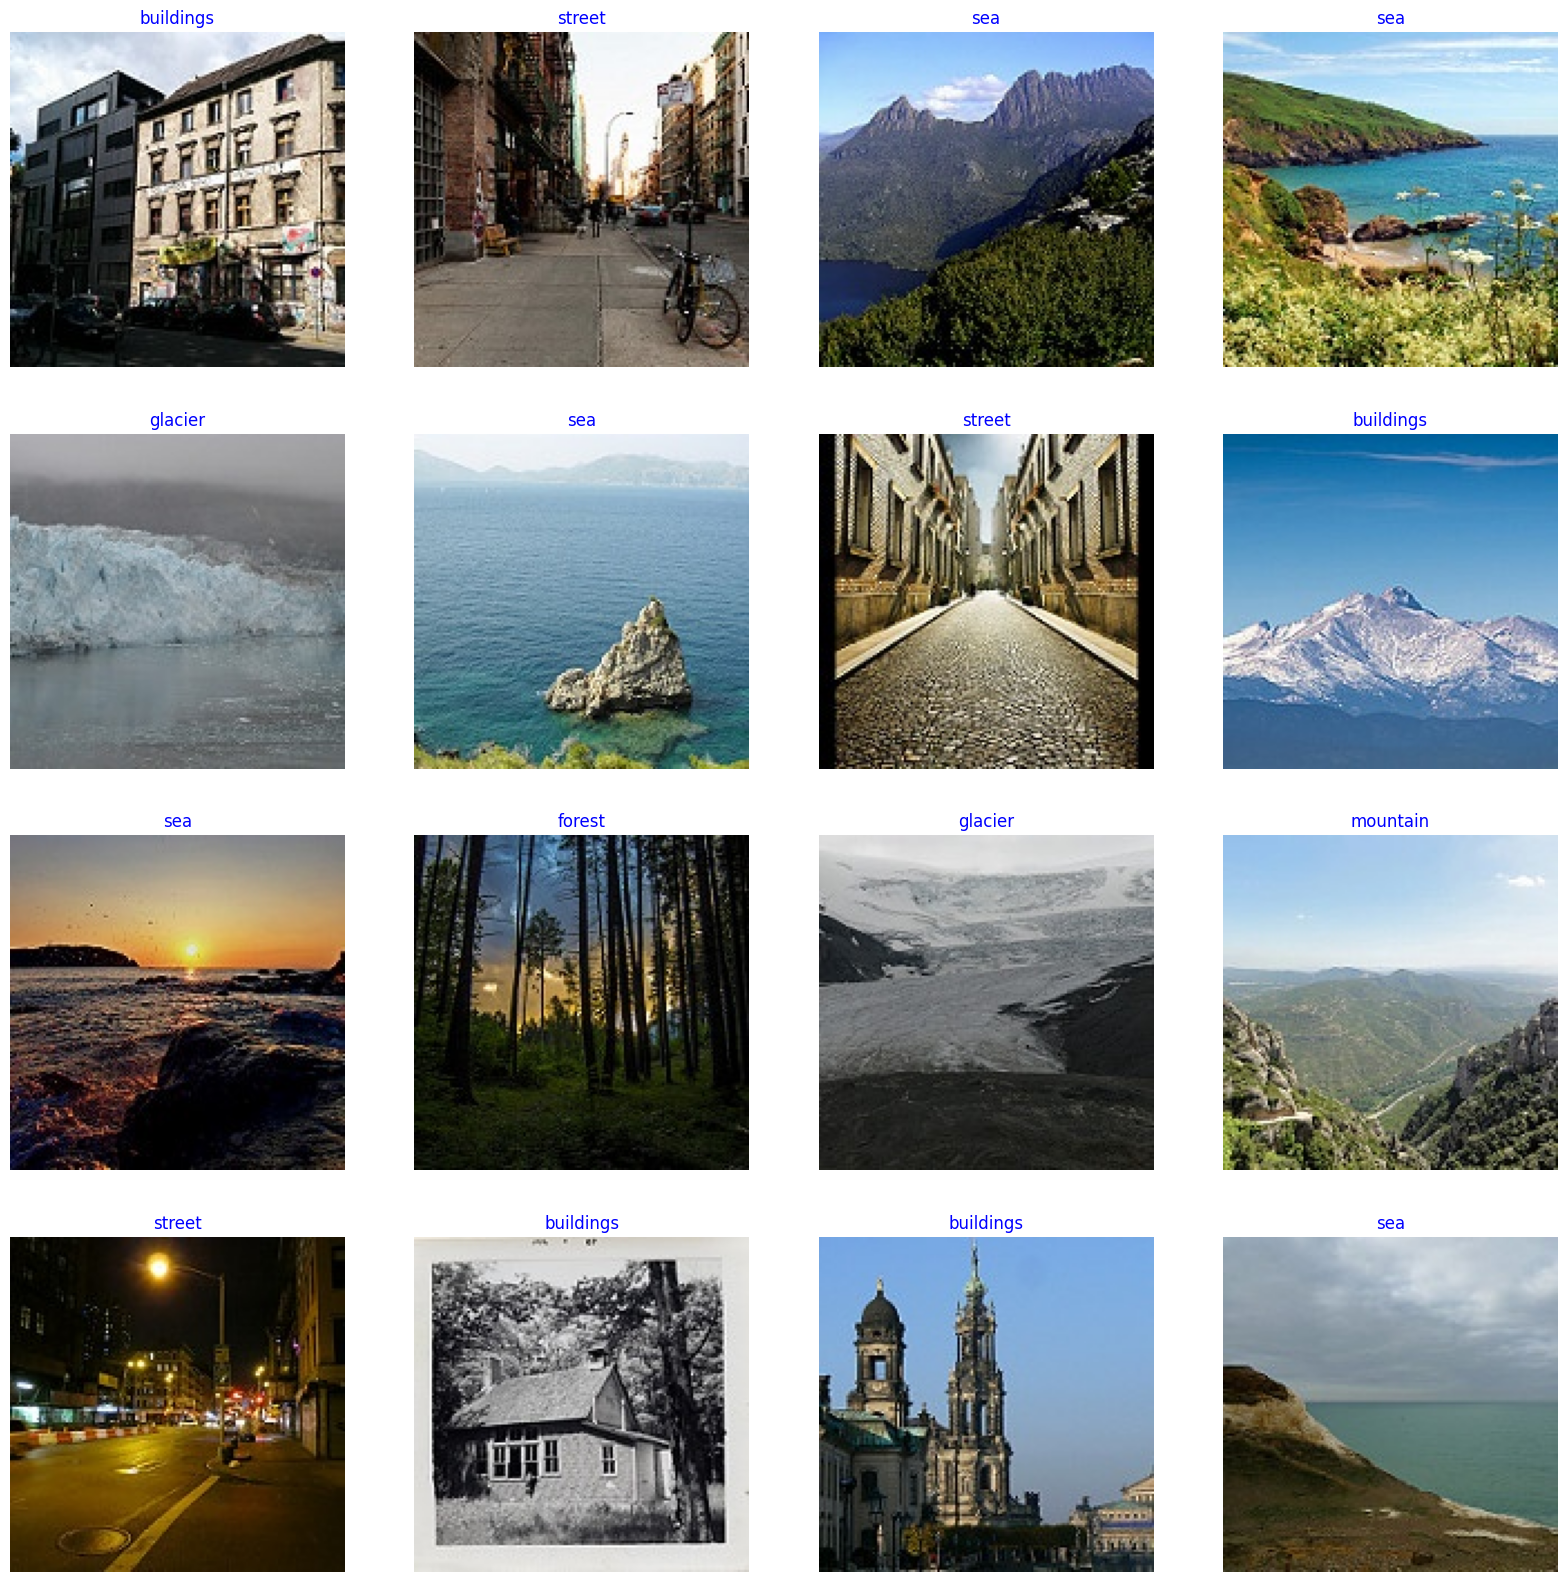

In [18]:
dict_gen = train_gen.class_indices
classes = list(dict_gen.keys())
images , labels = next(train_gen)

plt.figure(figsize=(20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

## Model Structure

In [19]:
img_shape = (img_size[0] , img_size[1] , 3)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False , weights= 'imagenet' , input_shape= img_shape , pooling= 'max')

num_classes = len(classes)

model = Sequential([
    base_model,
    BatchNormalization(axis = -1 , momentum = 0.99 , epsilon = 0.001),
    Dense(256 , activation= 'relu'),
    Dense(256 , activation= 'relu'),
    Dense(num_classes , activation= 'softmax')
])
model.compile(Adamax(learning_rate= 0.001) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

16705208/16705208 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 6)                 1542      
                                                         

Certainly! Let's break down the parameters and layers used in your TensorFlow Keras model step-by-step, explaining the role and effect of each one.

### **1. Base Model: EfficientNetB0**

```python
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=img_shape,
    pooling='max'
)
```

#### **Parameters:**

- **`include_top=False`**:
  - **Effect**: Excludes the fully connected layers (classification head) at the top of the EfficientNetB0 model. You are only using the convolutional base (feature extractor) of the network.

- **`weights='imagenet'`**:
  - **Effect**: Initializes the EfficientNetB0 model with weights pre-trained on the ImageNet dataset. This helps leverage learned features and transfer learning.

- **`input_shape=img_shape`**:
  - **Effect**: Specifies the shape of the input images. The `img_shape` variable should be a tuple like `(height, width, channels)`. For example, `(224, 224, 3)` for 224x224 RGB images.

- **`pooling='max'`**:
  - **Effect**: Applies global max pooling to the output of the base model, which reduces the spatial dimensions of the feature maps to a single vector per channel.

### **2. Additional Layers in the Model**

```python
model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])
```

#### **Layers and Parameters:**

- **`BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)`**:
  - **Effect**: Normalizes the outputs of the previous layer to stabilize and accelerate training.
  - **Parameters**:
    - **`axis=-1`**: Normalizes across the last axis (channels) of the input.
    - **`momentum=0.99`**: Decay factor for the moving average of mean and variance. Higher values mean slower changes.
    - **`epsilon=0.001`**: Small constant added to avoid division by zero in the normalization computation.

- **`Dense(256, activation='relu')`**:
  - **Effect**: Fully connected layer with 256 units and ReLU (Rectified Linear Unit) activation function. ReLU introduces non-linearity and allows the network to learn complex patterns.
  - **Parameters**:
    - **`256`**: Number of neurons in the dense layer.
    - **`activation='relu'`**: Applies the ReLU activation function, which outputs `max(0, x)` for input `x`.

- **`Dense(256, activation='relu')`**:
  - **Effect**: Another fully connected layer with 256 units and ReLU activation. It provides additional non-linear transformations and feature learning.
  - **Parameters**:
    - **`256`**: Number of neurons in the dense layer.
    - **`activation='relu'`**: ReLU activation function.

- **`Dense(num_classes, activation='softmax')`**:
  - **Effect**: Output layer for classification with `num_classes` neurons, each representing a class. Softmax activation converts logits to probabilities.
  - **Parameters**:
    - **`num_classes`**: Number of classes in the classification task.
    - **`activation='softmax'`**: Converts outputs to a probability distribution over classes.

### **3. Compile the Model**

```python
model.compile(
    Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
```

#### **Parameters:**

- **`Adamax(learning_rate=0.001)`**:
  - **Effect**: Specifies the optimizer used for training.
  - **Parameters**:
    - **`learning_rate=0.001`**: Step size for weight updates. A common starting value for Adamax.
    - **Adamax**: A variant of the Adam optimizer, more robust to gradient variability.

- **`loss='categorical_crossentropy'`**:
  - **Effect**: Specifies the loss function for the model.
  - **Parameters**:
    - **`categorical_crossentropy`**: Used for multi-class classification problems where the target labels are one-hot encoded vectors.

- **`metrics=['accuracy']`**:
  - **Effect**: Specifies the metrics to evaluate model performance during training and testing.
  - **Parameters**:
    - **`accuracy`**: Measures the proportion of correct predictions.

### **Summary**

Here's a high-level summary of what each component does:

- **EfficientNetB0**: Extracts features from the input images using a pre-trained, state-of-the-art model.
- **BatchNormalization**: Normalizes the features to stabilize and accelerate training.
- **Dense Layers**: Introduce non-linearities and learn high-level features.
- **Softmax Layer**: Converts the final output into class probabilities.
- **Adamax Optimizer**: Optimizes the weights of the network using a robust variant of the Adam optimizer.
- **Categorical Crossentropy Loss**: Measures the performance of the classification model.
- **Accuracy Metric**: Evaluates the proportion of correct predictions.

### **Visual Diagram**

Here is a simplified diagram to visualize the architecture:

```
Input (img_shape) --> EfficientNetB0 (feature extraction) --> BatchNormalization
                                                            --> Dense (256, ReLU) --> Dense (256, ReLU) --> Dense (num_classes, Softmax)
```

### **Effects of Each Component**

- **EfficientNetB0**: Feature extraction and representation.
- **BatchNormalization**: Stabilizes and speeds up training.
- **Dense Layers**: Learn and transform features.
- **Softmax**: Produces class probabilities.
- **Adamax**: Updates weights based on gradients.
- **Categorical Crossentropy**: Measures performance for multi-class classification.
- **Accuracy**: Tracks the percentage of correct classifications.

Each part of the model and the training configuration is chosen to optimize performance and leverage pre-existing knowledge from the ImageNet dataset, while also ensuring that the model can generalize well to the specific classification task you are addressing.

If you have more specific questions about any of these components or need additional details, feel free to ask!

## Training

In [20]:
epochs = 10

history = model.fit(x = original_train_gen , epochs =epochs , verbose = 1 ,validation_data= valid_gen,validation_steps=None , shuffle = False )

Epoch 1/10
533/533 [==============================] - 134s 180ms/step - loss: 0.7875 - accuracy: 0.7898 - val_loss: 0.5188 - val_accuracy: 0.8515
Epoch 2/10
533/533 [==============================] - 84s 158ms/step - loss: 0.6027 - accuracy: 0.8410 - val_loss: 0.3684 - val_accuracy: 0.8947
Epoch 3/10
533/533 [==============================] - 84s 158ms/step - loss: 0.4831 - accuracy: 0.8645 - val_loss: 0.2548 - val_accuracy: 0.9267
Epoch 4/10
533/533 [==============================] - 83s 156ms/step - loss: 0.3658 - accuracy: 0.8897 - val_loss: 0.1488 - val_accuracy: 0.9605
Epoch 5/10
533/533 [==============================] - 83s 155ms/step - loss: 0.2623 - accuracy: 0.9163 - val_loss: 0.0950 - val_accuracy: 0.9840
Epoch 6/10
533/533 [==============================] - 83s 157ms/step - loss: 0.1788 - accuracy: 0.9424 - val_loss: 0.0884 - val_accuracy: 0.9755
Epoch 7/10
533/533 [==============================] - 83s 156ms/step - loss: 0.1328 - accuracy: 0.9567 - val_loss: 0.0336 - val_a

## Model Performance

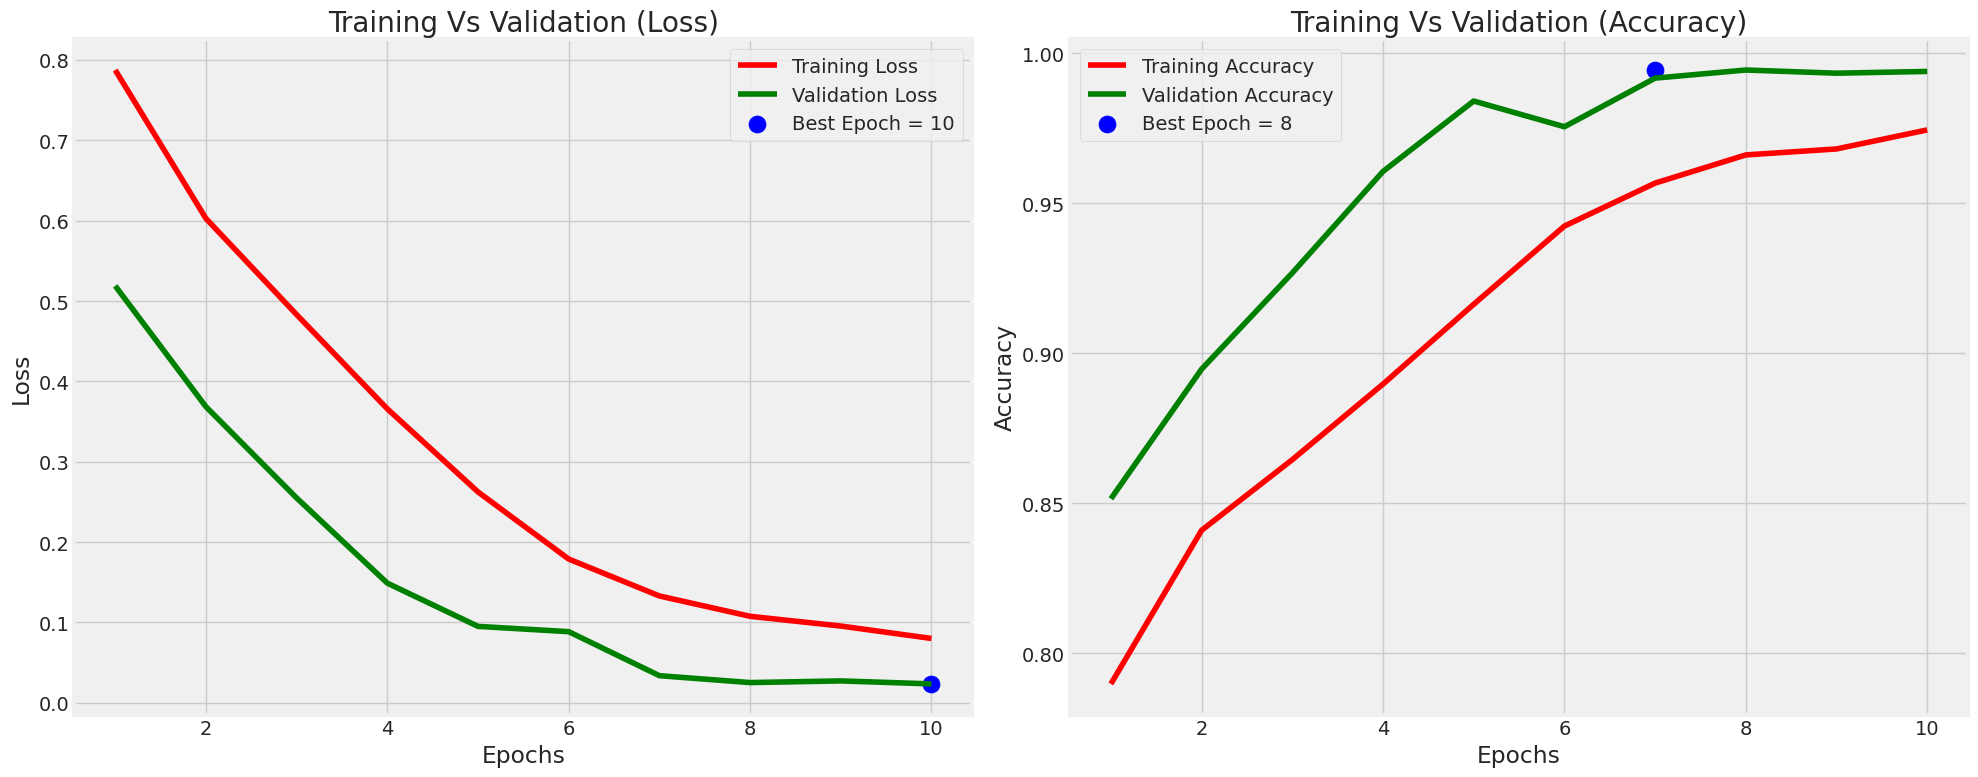

In [21]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)
val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_loss = f'Best Epoch = {str(index_acc +1)}'

#Training Accuracy
plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue' , label= loss_label)
plt.title('Training Vs Validation (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs , train_acc , 'r' , label= 'Training Accuracy')
plt.plot(epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc , val_highest , s= 150 , c= 'blue' , label = acc_loss)
plt.title('Training Vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show();

## Model Evaluation

In [22]:
train_score = model.evaluate(train_gen , steps = 32 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 32 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 32 , verbose = 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

32/32 [==============================] - 2s 60ms/step - loss: 0.0224 - accuracy: 0.9941
Train Loss:  1.378570795059204
Train Accuracy:  0.89453125
--------------------
Validation Loss:  0.021555494517087936
Validation Accuracy:  0.9951171875
--------------------
Test Loss:  0.022419407963752747
Test Accuracy:  0.994140625


## Model Prediction

### Confusion Matrix

In [23]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds , axis = 1)

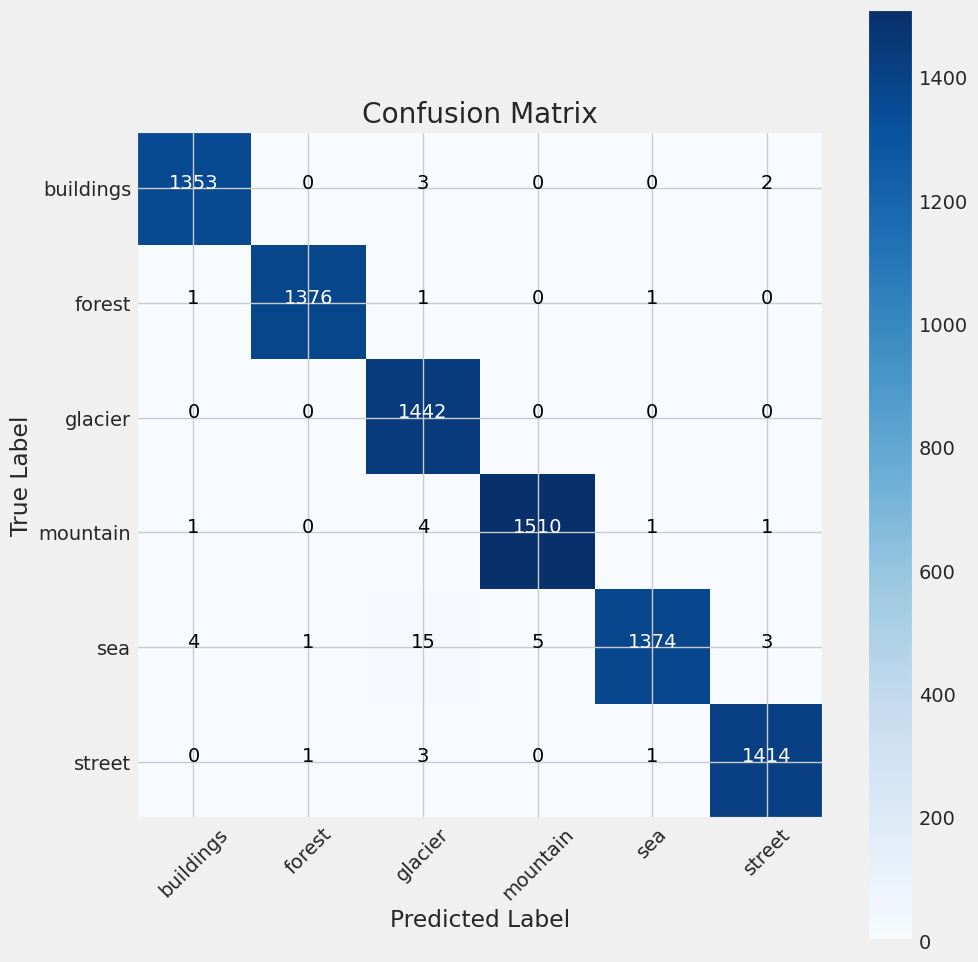

In [24]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

### Classification report

In [25]:
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

   buildings       1.00      1.00      1.00      1358
      forest       1.00      1.00      1.00      1379
     glacier       0.98      1.00      0.99      1442
    mountain       1.00      1.00      1.00      1517
         sea       1.00      0.98      0.99      1402
      street       1.00      1.00      1.00      1419

    accuracy                           0.99      8517
   macro avg       0.99      0.99      0.99      8517
weighted avg       0.99      0.99      0.99      8517



In [26]:
base_model = ResNet50(include_top= False , weights= 'imagenet' , input_shape= img_shape , pooling= 'max')

num_classes = len(classes)

model2 = Sequential([
    base_model,
    BatchNormalization(axis = -1 , momentum = 0.99 , epsilon = 0.001),
    Dense(256 , activation= 'relu'),
    Dense(256 , activation= 'relu'),
    Dense(num_classes , activation= 'softmax')
])
model2.compile(Adamax(learning_rate= 0.001) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model2.summary()

94765736/94765736 [==============================] - 6s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 24187782 (92.27 MB)
Trainable params: 241

In [27]:
epochs = 10

history2 = model2.fit(x = original_train_gen , epochs =epochs , verbose = 1 ,validation_data= valid_gen,validation_steps=None , shuffle = False )

Epoch 1/10
533/533 [==============================] - 157s 228ms/step - loss: 0.8610 - accuracy: 0.7606 - val_loss: 0.6373 - val_accuracy: 0.8349
Epoch 2/10
533/533 [==============================] - 117s 220ms/step - loss: 0.7025 - accuracy: 0.8143 - val_loss: 0.7537 - val_accuracy: 0.7600
Epoch 3/10
533/533 [==============================] - 123s 230ms/step - loss: 0.6577 - accuracy: 0.8257 - val_loss: 0.7544 - val_accuracy: 0.7722
Epoch 4/10
533/533 [==============================] - 123s 230ms/step - loss: 0.5911 - accuracy: 0.8419 - val_loss: 0.5820 - val_accuracy: 0.8173
Epoch 5/10
533/533 [==============================] - 117s 220ms/step - loss: 0.4978 - accuracy: 0.8640 - val_loss: 0.5872 - val_accuracy: 0.8141
Epoch 6/10
533/533 [==============================] - 117s 220ms/step - loss: 0.3768 - accuracy: 0.8916 - val_loss: 0.3183 - val_accuracy: 0.9040
Epoch 7/10
533/533 [==============================] - 117s 220ms/step - loss: 0.2497 - accuracy: 0.9237 - val_loss: 0.1897 -

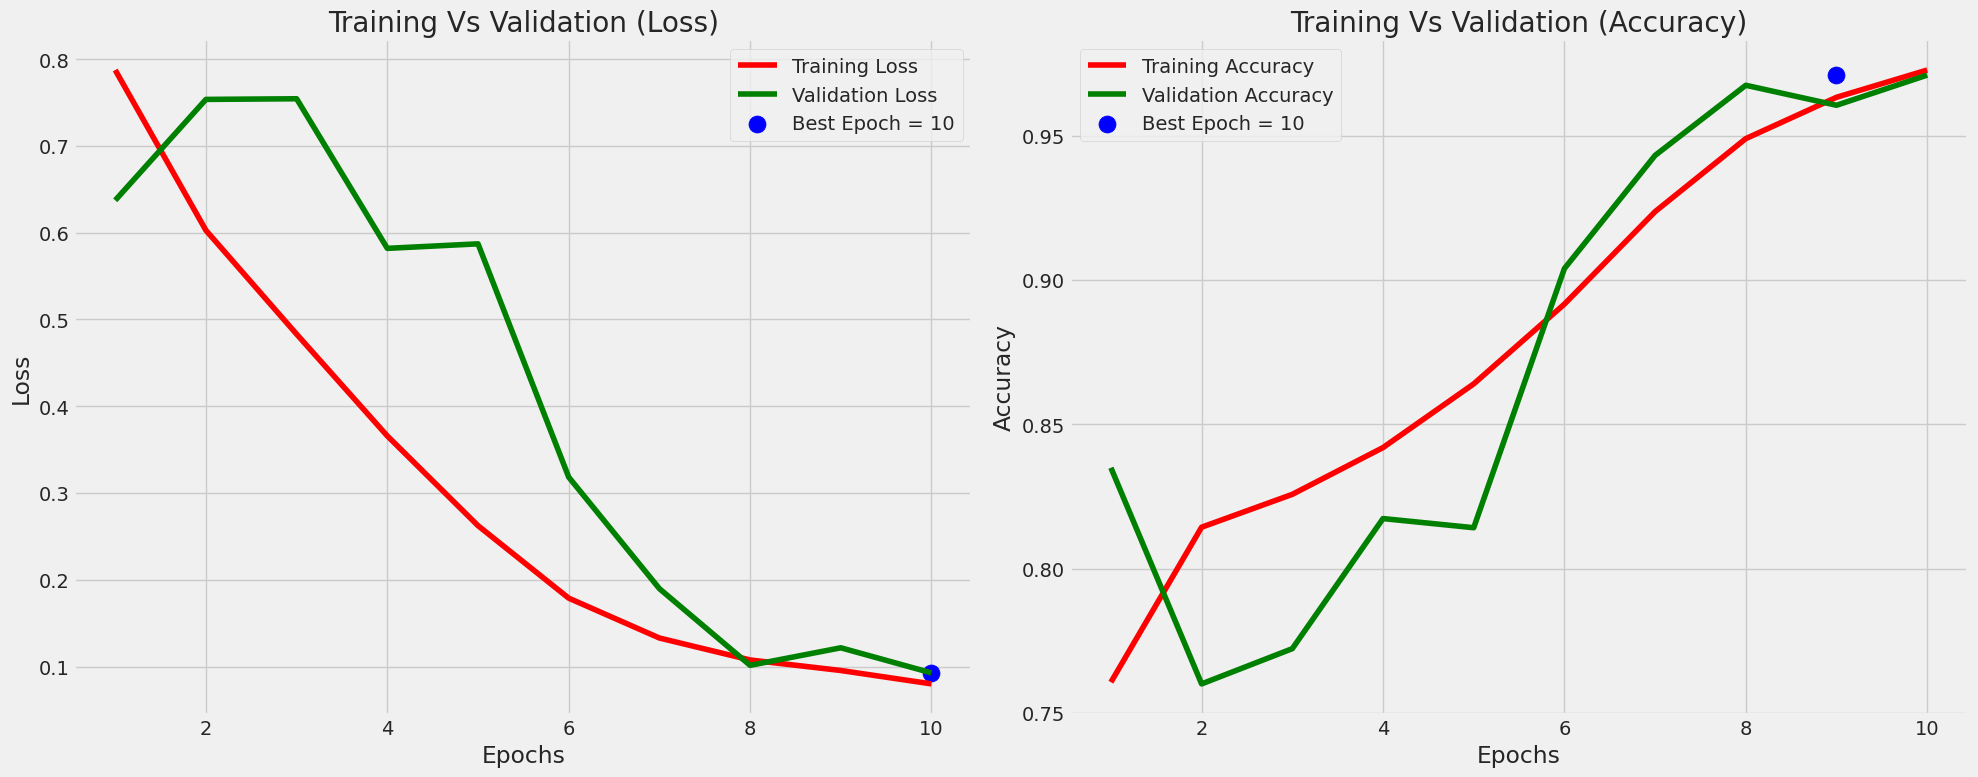

In [28]:
train_acc = history2.history['accuracy']
train_loss = history.history['loss']

val_acc = history2.history['val_accuracy']
val_loss = history2.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)
val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_loss = f'Best Epoch = {str(index_acc +1)}'

#Training Accuracy
plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue' , label= loss_label)
plt.title('Training Vs Validation (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs , train_acc , 'r' , label= 'Training Accuracy')
plt.plot(epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc , val_highest , s= 150 , c= 'blue' , label = acc_loss)
plt.title('Training Vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show();

## Model(s) for the flipped images

In [29]:
img_shape = (img_size[0] , img_size[1] , 3)
base_model1 = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False , weights= 'imagenet' , input_shape= img_shape , pooling= 'max')

num_classes = len(classes)

model1 = Sequential([
    base_model1,
    BatchNormalization(axis = -1 , momentum = 0.99 , epsilon = 0.001),
    Dense(256 , activation= 'relu'),
    Dense(256 , activation= 'relu'),
    Dense(num_classes , activation= 'softmax')
])
model1.compile(Adamax(learning_rate= 0.001) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [30]:
epochs = 10

history1 = model1.fit(x = train_gen , epochs =epochs , verbose = 1 ,validation_data= valid_gen,validation_steps=None , shuffle = False )

Epoch 1/10
533/533 [==============================] - 114s 159ms/step - loss: 1.0640 - accuracy: 0.6981 - val_loss: 0.5921 - val_accuracy: 0.8559
Epoch 2/10
533/533 [==============================] - 83s 156ms/step - loss: 0.8868 - accuracy: 0.7507 - val_loss: 0.5428 - val_accuracy: 0.8643
Epoch 3/10
533/533 [==============================] - 83s 156ms/step - loss: 0.7777 - accuracy: 0.7759 - val_loss: 0.4443 - val_accuracy: 0.8752
Epoch 4/10
533/533 [==============================] - 82s 154ms/step - loss: 0.6246 - accuracy: 0.8049 - val_loss: 0.4231 - val_accuracy: 0.8780
Epoch 5/10
533/533 [==============================] - 85s 159ms/step - loss: 0.4678 - accuracy: 0.8472 - val_loss: 0.4387 - val_accuracy: 0.8824
Epoch 6/10
533/533 [==============================] - 85s 160ms/step - loss: 0.3239 - accuracy: 0.8915 - val_loss: 0.5448 - val_accuracy: 0.8894
Epoch 7/10
533/533 [==============================] - 85s 159ms/step - loss: 0.2363 - accuracy: 0.9225 - val_loss: 0.7031 - val_a

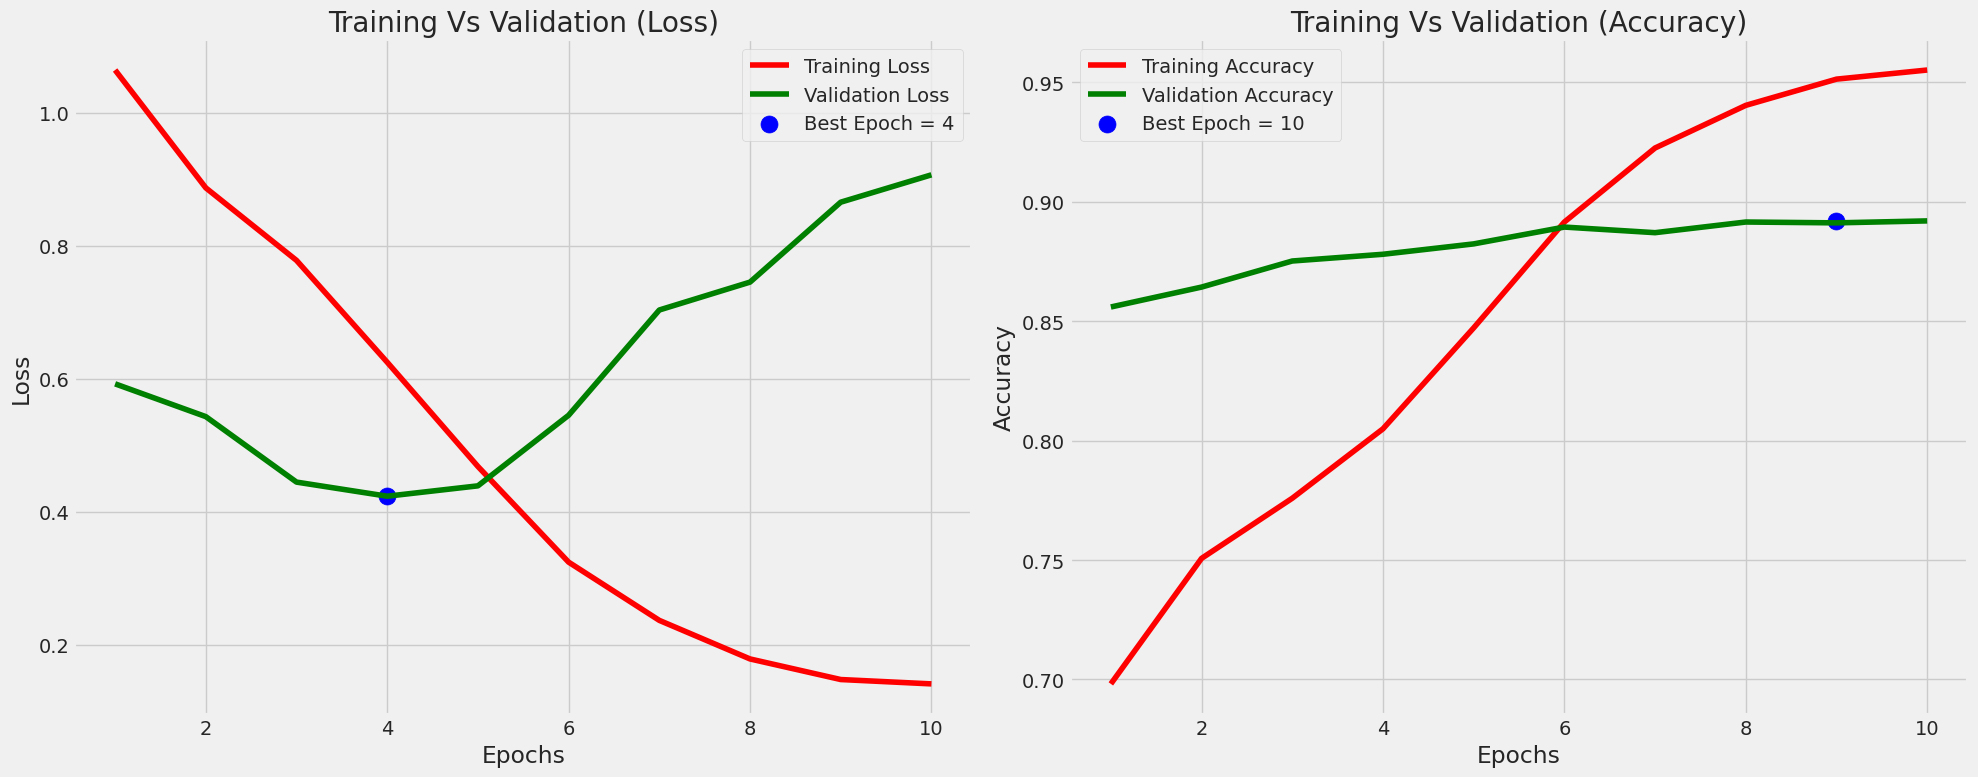

In [31]:
train_acc = history1.history['accuracy']
train_loss = history1.history['loss']

val_acc = history1.history['val_accuracy']
val_loss = history1.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)
val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_loss = f'Best Epoch = {str(index_acc +1)}'

#Training Accuracy
plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue' , label= loss_label)
plt.title('Training Vs Validation (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs , train_acc , 'r' , label= 'Training Accuracy')
plt.plot(epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc , val_highest , s= 150 , c= 'blue' , label = acc_loss)
plt.title('Training Vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show();